In [2]:
%pip install pandas seaborn randon matplotlib scipy numpy

Note: you may need to restart the kernel to use updated packages.


# Importações e Configurações

In [3]:
#!/usr/bin/env python3
"""
Etapa 2: Integração e Limpeza de Dados
Projeto Final - Ciência de Dados: Métricas de Código Go
Dataset: Métricas de Código Go para Predição de Refatoração
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

warnings.filterwarnings("ignore")

# Configuração de estilo profissional
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["figure.dpi"] = 300

# Carregamento e Limpeza Inicial dos Dados

In [4]:
# Carregar dados
df = pd.read_csv("go_metrics.csv")
print(f"Dataset carregado: {df.shape[0]} entidades, {df.shape[1]} features")

# Remover duplicatas
initial_count = len(df)
df = df.drop_duplicates()
print(f"{initial_count - len(df)} duplicatas removidas")

# Definir colunas de métricas
metrics_cols = ["loc", "nom", "nof", "wmc", "cbo", "rfc", "lcom"]

Dataset carregado: 14 entidades, 11 features
0 duplicatas removidas


# Função Auxiliar para Plotagem

In [5]:
def safe_kde_plot(data, ax, color="#A23B72", label="Densidade"):
    """Plot KDE seguro que lida com dados de baixa variância"""
    try:
        # Remove NaN e inf
        clean_data = data.dropna()
        if len(clean_data) < 2:
            return

        # Verifica se há variância suficiente
        if clean_data.std() > 1e-10:  # Threshold mínimo de variância
            # Usa o KDE do seaborn que é mais robusto
            sns.kdeplot(clean_data, ax=ax, color=color, linewidth=2.5, label=label)
        else:
            # Para dados com pouca variância, plota uma linha vertical
            ax.axvline(clean_data.iloc[0], color=color, linewidth=2.5, label=label)
    except Exception as e:
        print(f"Aviso: Não foi possível plotar KDE para {data.name}: {e}")

# Análise de Outliers

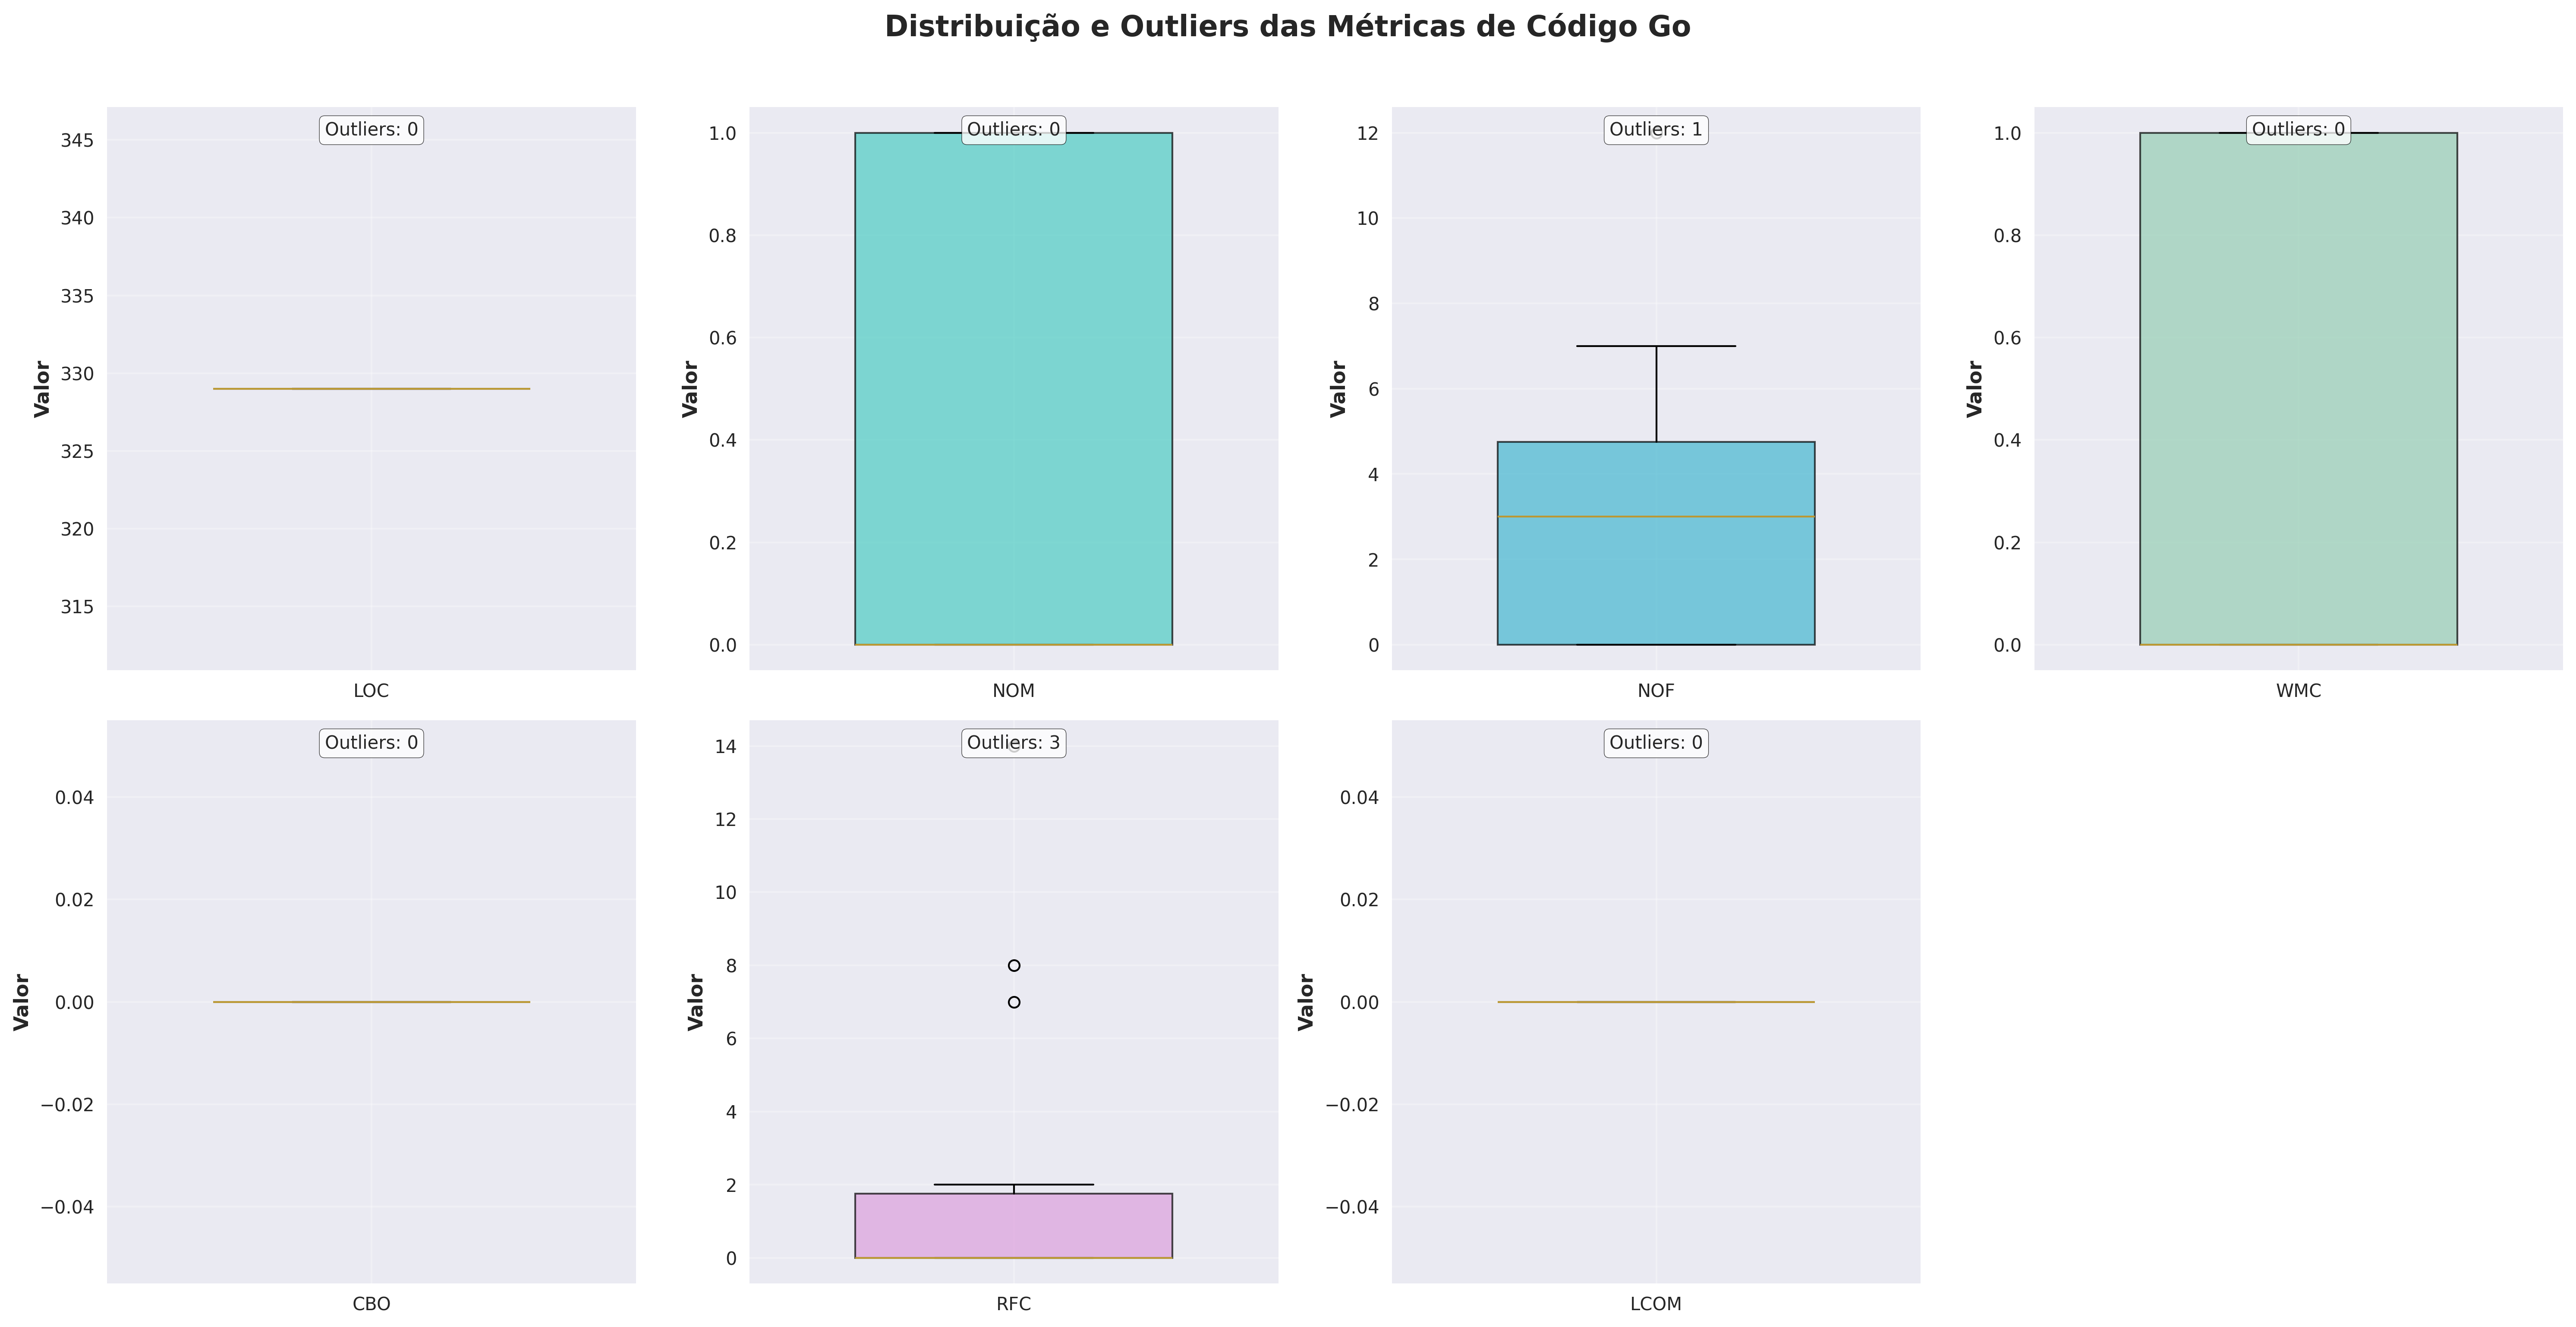

In [6]:
# Análise de Outliers - Boxplots
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle(
    "Distribuição e Outliers das Métricas de Código Go",
    fontsize=16,
    fontweight="bold",
    y=1.02,
)

for idx, col in enumerate(metrics_cols):
    ax = axes[idx // 4, idx % 4]

    # Boxplot com cores por quartis
    box_plot = ax.boxplot(df[col], patch_artist=True, labels=[col.upper()], widths=0.6)

    # Customização das cores
    colors = [
        "#FF6B6B",
        "#4ECDC4",
        "#45B7D1",
        "#96CEB4",
        "#FFEAA7",
        "#DDA0DD",
        "#98D8C8",
    ]
    box_plot["boxes"][0].set_facecolor(colors[idx % len(colors)])
    box_plot["boxes"][0].set_alpha(0.7)

    # Estatísticas
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR)]

    ax.text(
        0.5,
        0.95,
        f"Outliers: {len(outliers)}",
        transform=ax.transAxes,
        ha="center",
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
    )

    ax.set_ylabel("Valor", fontweight="bold")
    ax.grid(True, alpha=0.3)

# Remover subplot vazio
axes[1, 3].remove()

plt.tight_layout()
plt.show()

# Distribuições Detalhadas

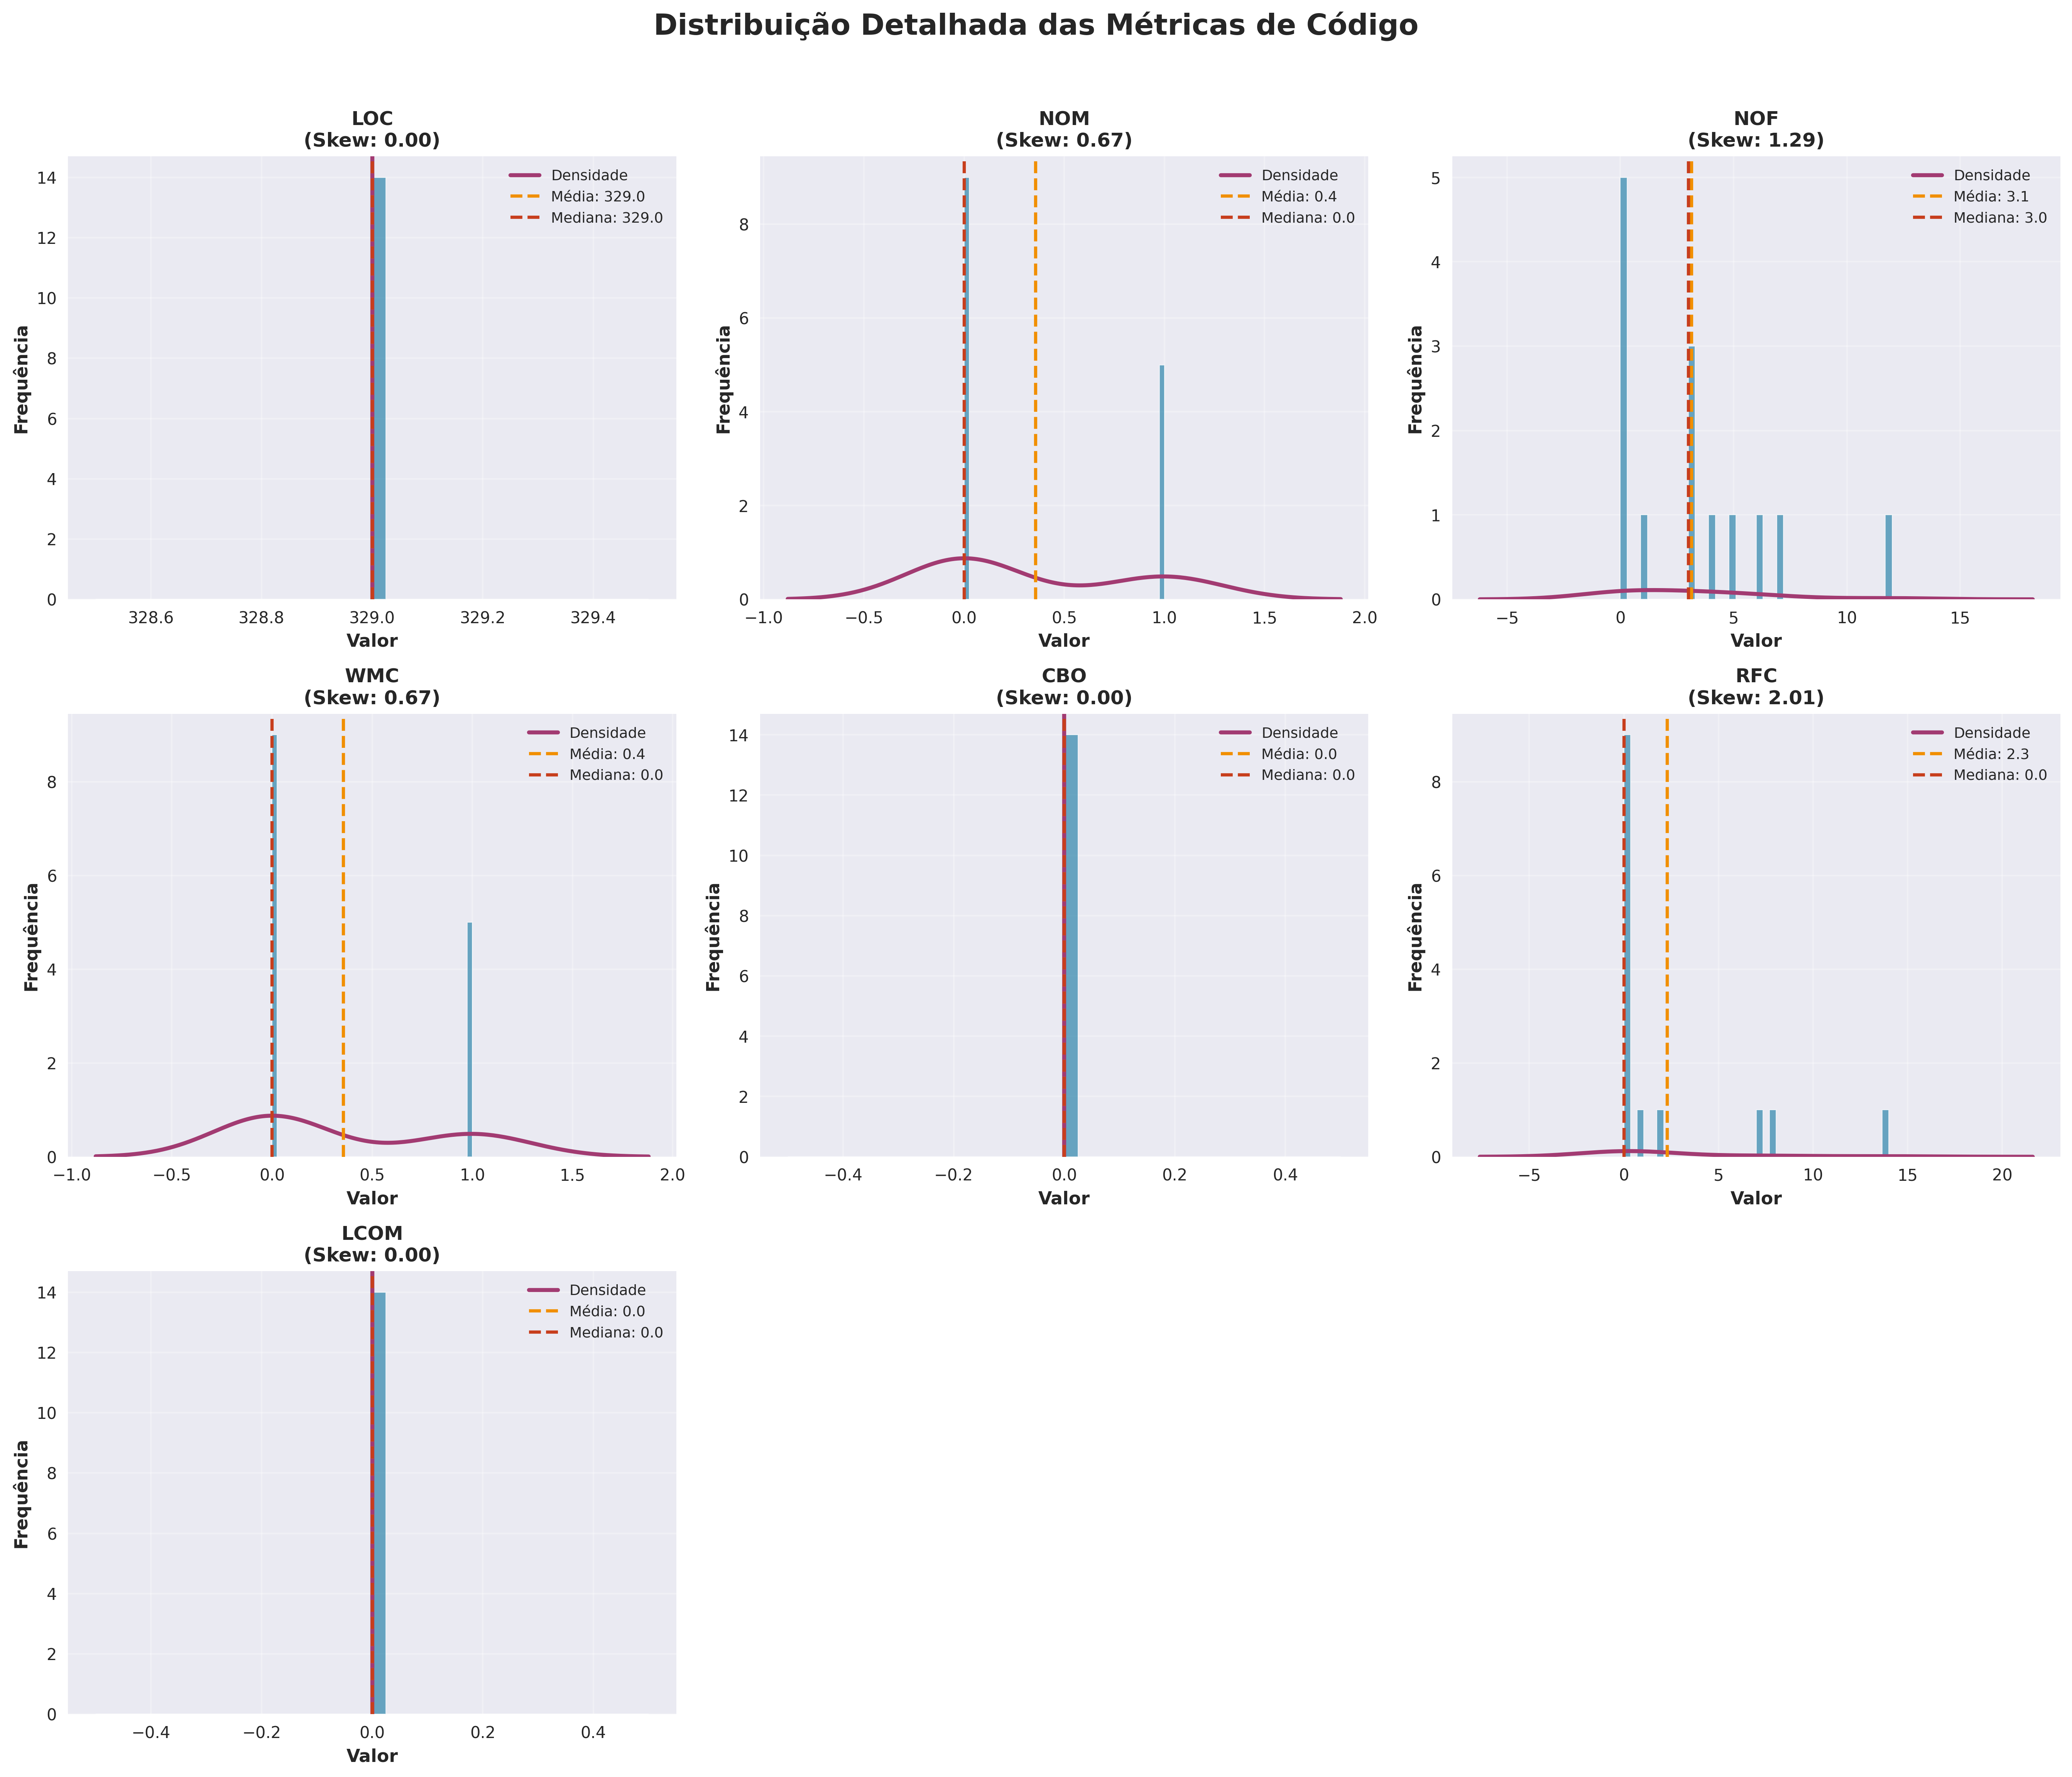

In [7]:
# Distribuições Detalhadas
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.suptitle(
    "Distribuição Detalhada das Métricas de Código",
    fontsize=18,
    fontweight="bold",
    y=1.02,
)

for idx, col in enumerate(metrics_cols):
    ax = axes[idx // 3, idx % 3]

    # Histograma seguro
    n, bins, patches = ax.hist(
        df[col],
        bins=40,
        alpha=0.7,
        color="#2E86AB",
        edgecolor="white",
        linewidth=0.5,
        density=False,
    )

    # KDE seguro (sem causar erro)
    safe_kde_plot(df[col], ax)

    # Estatísticas
    mean_val = df[col].mean()
    median_val = df[col].median()
    skew_val = df[col].skew()

    # Linhas de referência
    ax.axvline(
        mean_val,
        color="#F18F01",
        linestyle="--",
        linewidth=2,
        label=f"Média: {mean_val:.1f}",
    )
    ax.axvline(
        median_val,
        color="#C73E1D",
        linestyle="--",
        linewidth=2,
        label=f"Mediana: {median_val:.1f}",
    )

    ax.set_title(
        f"{col.upper()}\n(Skew: {skew_val:.2f})", fontweight="bold", fontsize=12
    )
    ax.set_xlabel("Valor", fontweight="bold")
    ax.set_ylabel("Frequência", fontweight="bold")
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

# Remover subplots vazios
for i in range(len(metrics_cols), 9):
    axes[i // 3, i % 3].remove()

plt.tight_layout()
plt.show()

# Análise por Tipo de Entidade

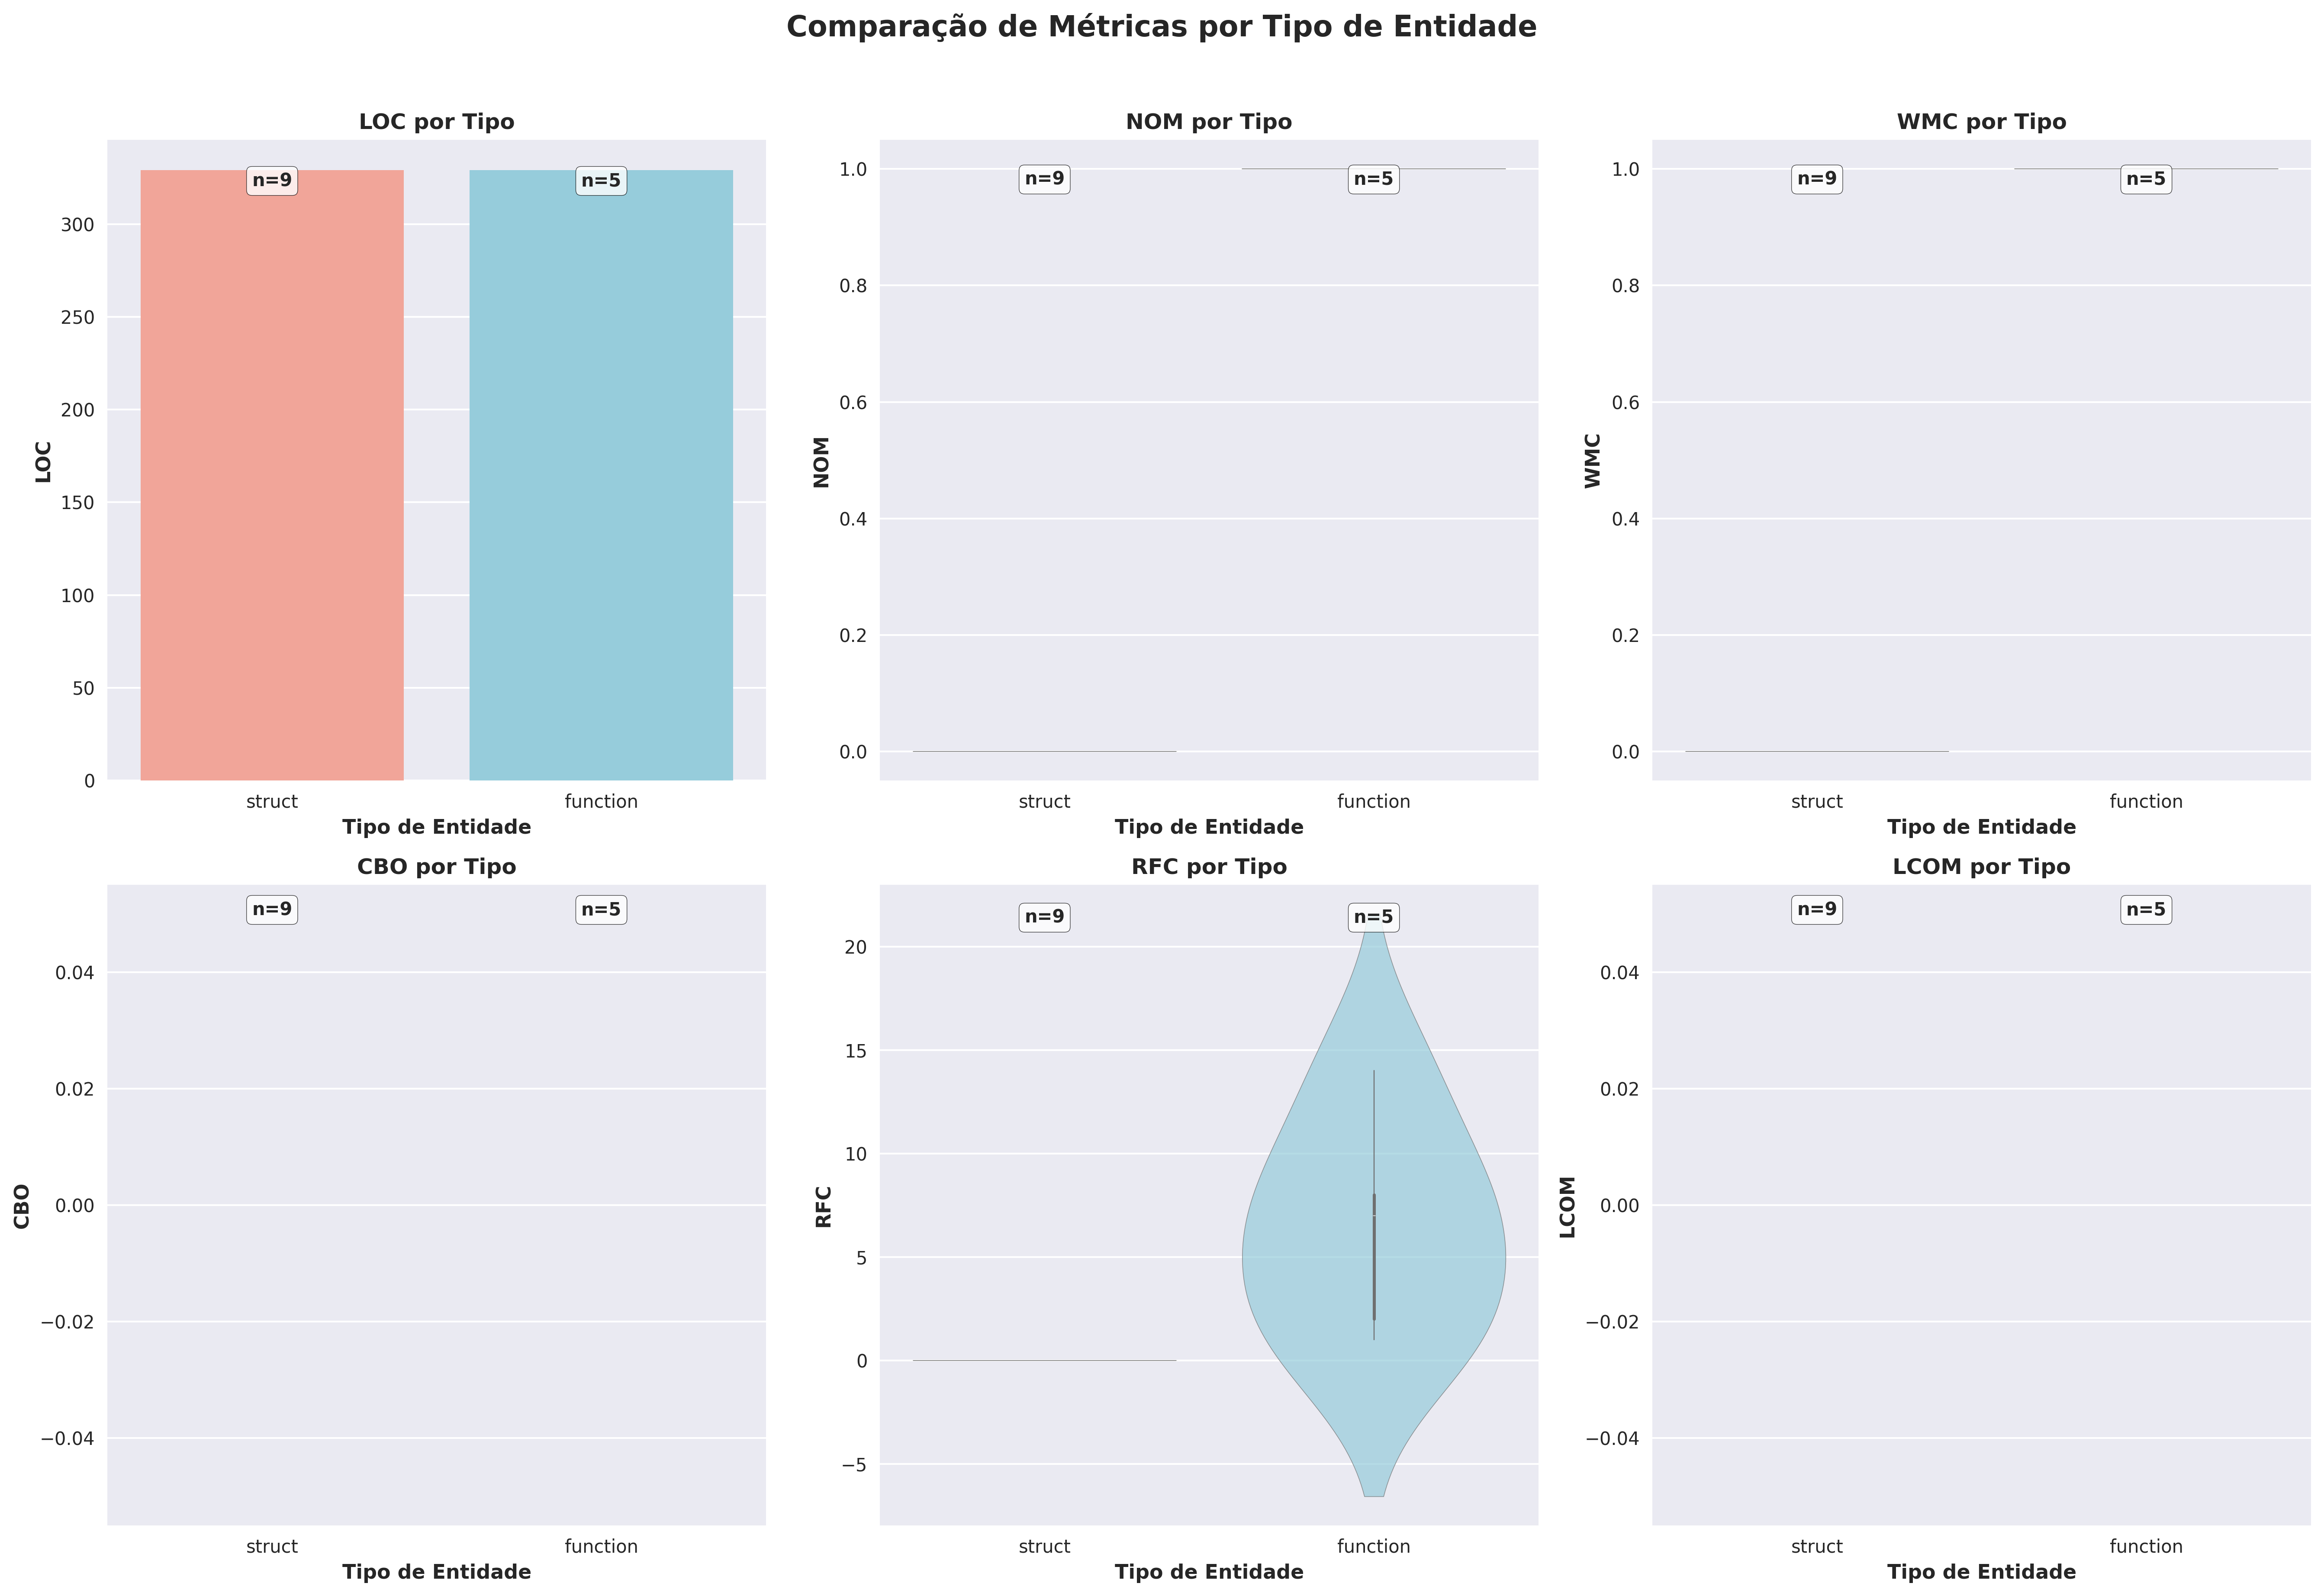

In [8]:
# Análise por Tipo de Entidade
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle(
    "Comparação de Métricas por Tipo de Entidade",
    fontsize=16,
    fontweight="bold",
    y=1.02,
)

metrics_to_compare = ["loc", "nom", "wmc", "cbo", "rfc", "lcom"]

for idx, metric in enumerate(metrics_to_compare):
    ax = axes[idx // 3, idx % 3]

    # Verificar se há dados suficientes para violino plot
    if len(df) > 1 and df[metric].std() > 0:
        try:
            # Violin plot combinado com boxplot
            sns.violinplot(
                data=df,
                x="type",
                y=metric,
                ax=ax,
                palette=["#FF9A8B", "#8BD3E6"],
                inner="box",
                alpha=0.7,
            )
        except:
            # Fallback para boxplot simples
            sns.boxplot(
                data=df, x="type", y=metric, ax=ax, palette=["#FF9A8B", "#8BD3E6"]
            )
    else:
        # Bar plot para dados muito simples
        sns.barplot(data=df, x="type", y=metric, ax=ax, palette=["#FF9A8B", "#8BD3E6"])

    ax.set_title(f"{metric.upper()} por Tipo", fontweight="bold")
    ax.set_xlabel("Tipo de Entidade", fontweight="bold")
    ax.set_ylabel(metric.upper(), fontweight="bold")

    # Adicionar contagens
    for i, entity_type in enumerate(df["type"].unique()):
        count = len(df[df["type"] == entity_type])
        ax.text(
            i,
            ax.get_ylim()[1] * 0.95,
            f"n={count}",
            ha="center",
            va="top",
            fontweight="bold",
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
        )

plt.tight_layout()
plt.show()

#  Matriz de Correlação

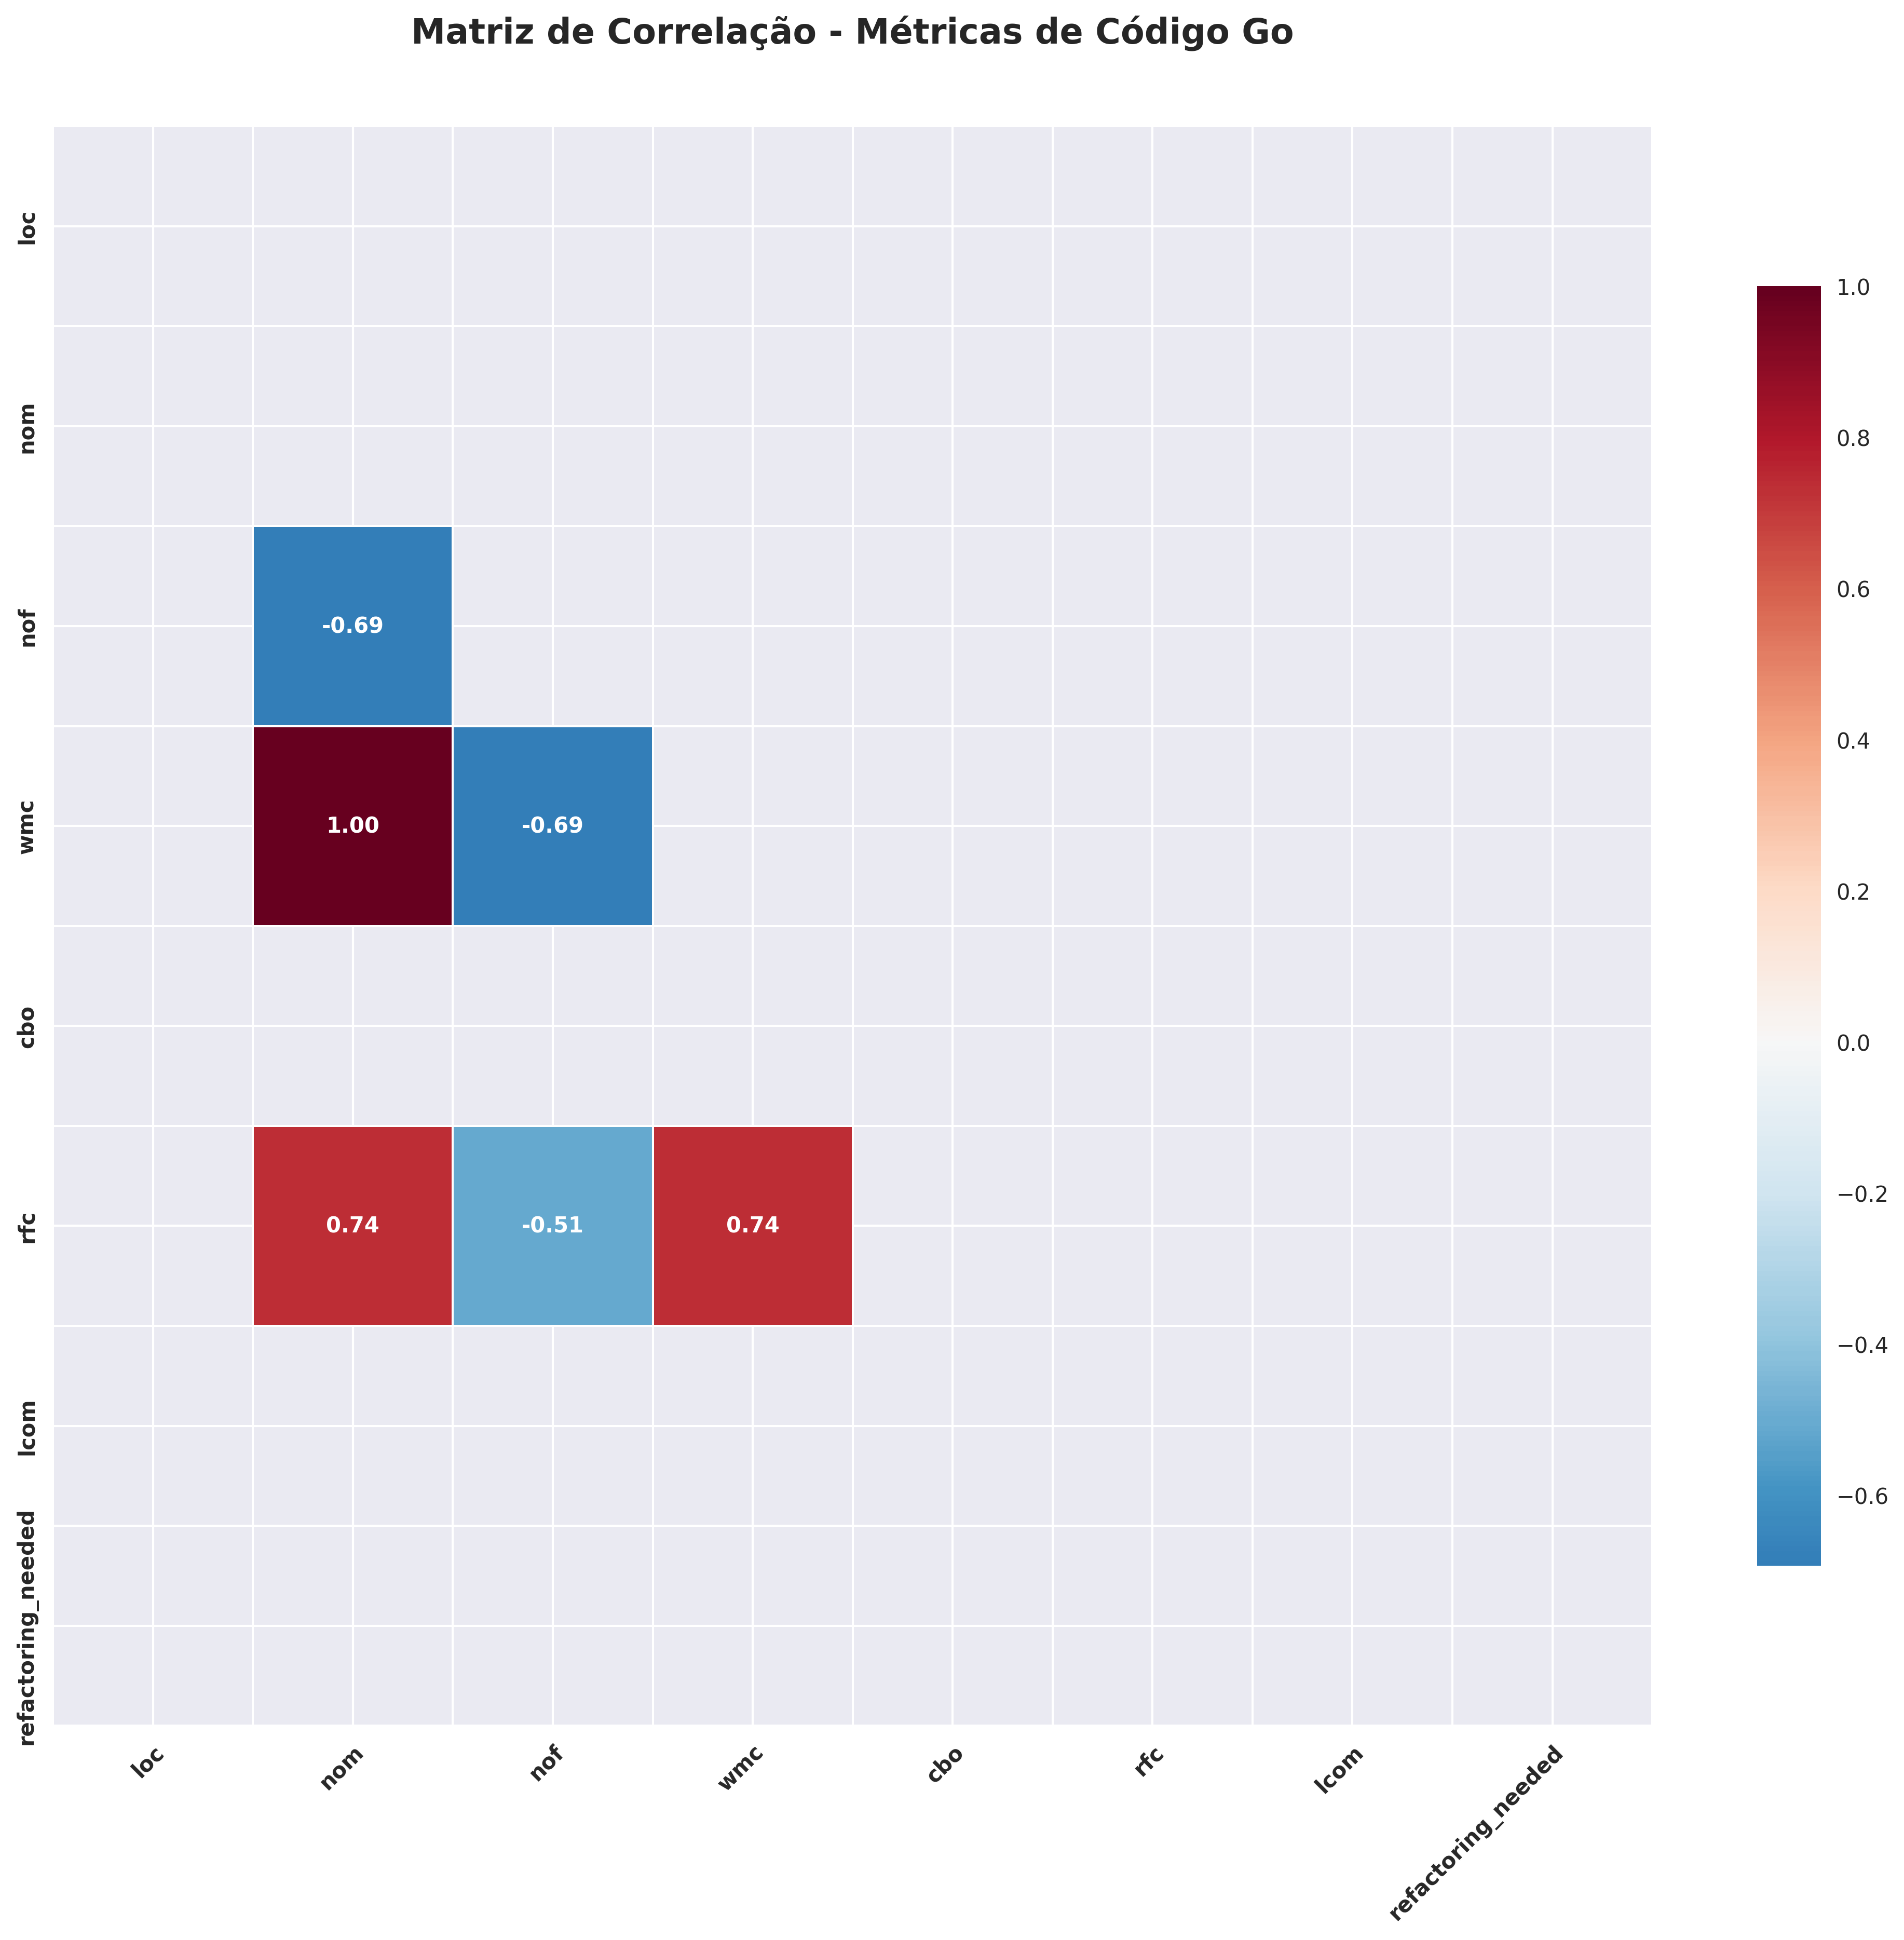

In [9]:
# Matriz de Correlação
fig, ax = plt.subplots(figsize=(14, 12))

# Calcular correlação
corr_matrix = df[metrics_cols + ["refactoring_needed"]].corr()

# Máscara para o triângulo superior
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Heatmap avançado
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    ax=ax,
    annot_kws={"size": 10, "weight": "bold"},
)

ax.set_title(
    "Matriz de Correlação - Métricas de Código Go\n",
    fontsize=16,
    fontweight="bold",
    pad=20,
)

# Rotacionar labels
plt.setp(
    ax.get_xticklabels(),
    rotation=45,
    ha="right",
    rotation_mode="anchor",
    fontweight="bold",
)
plt.setp(ax.get_yticklabels(), fontweight="bold")

plt.tight_layout()
plt.show()

# Análise de Refatoração

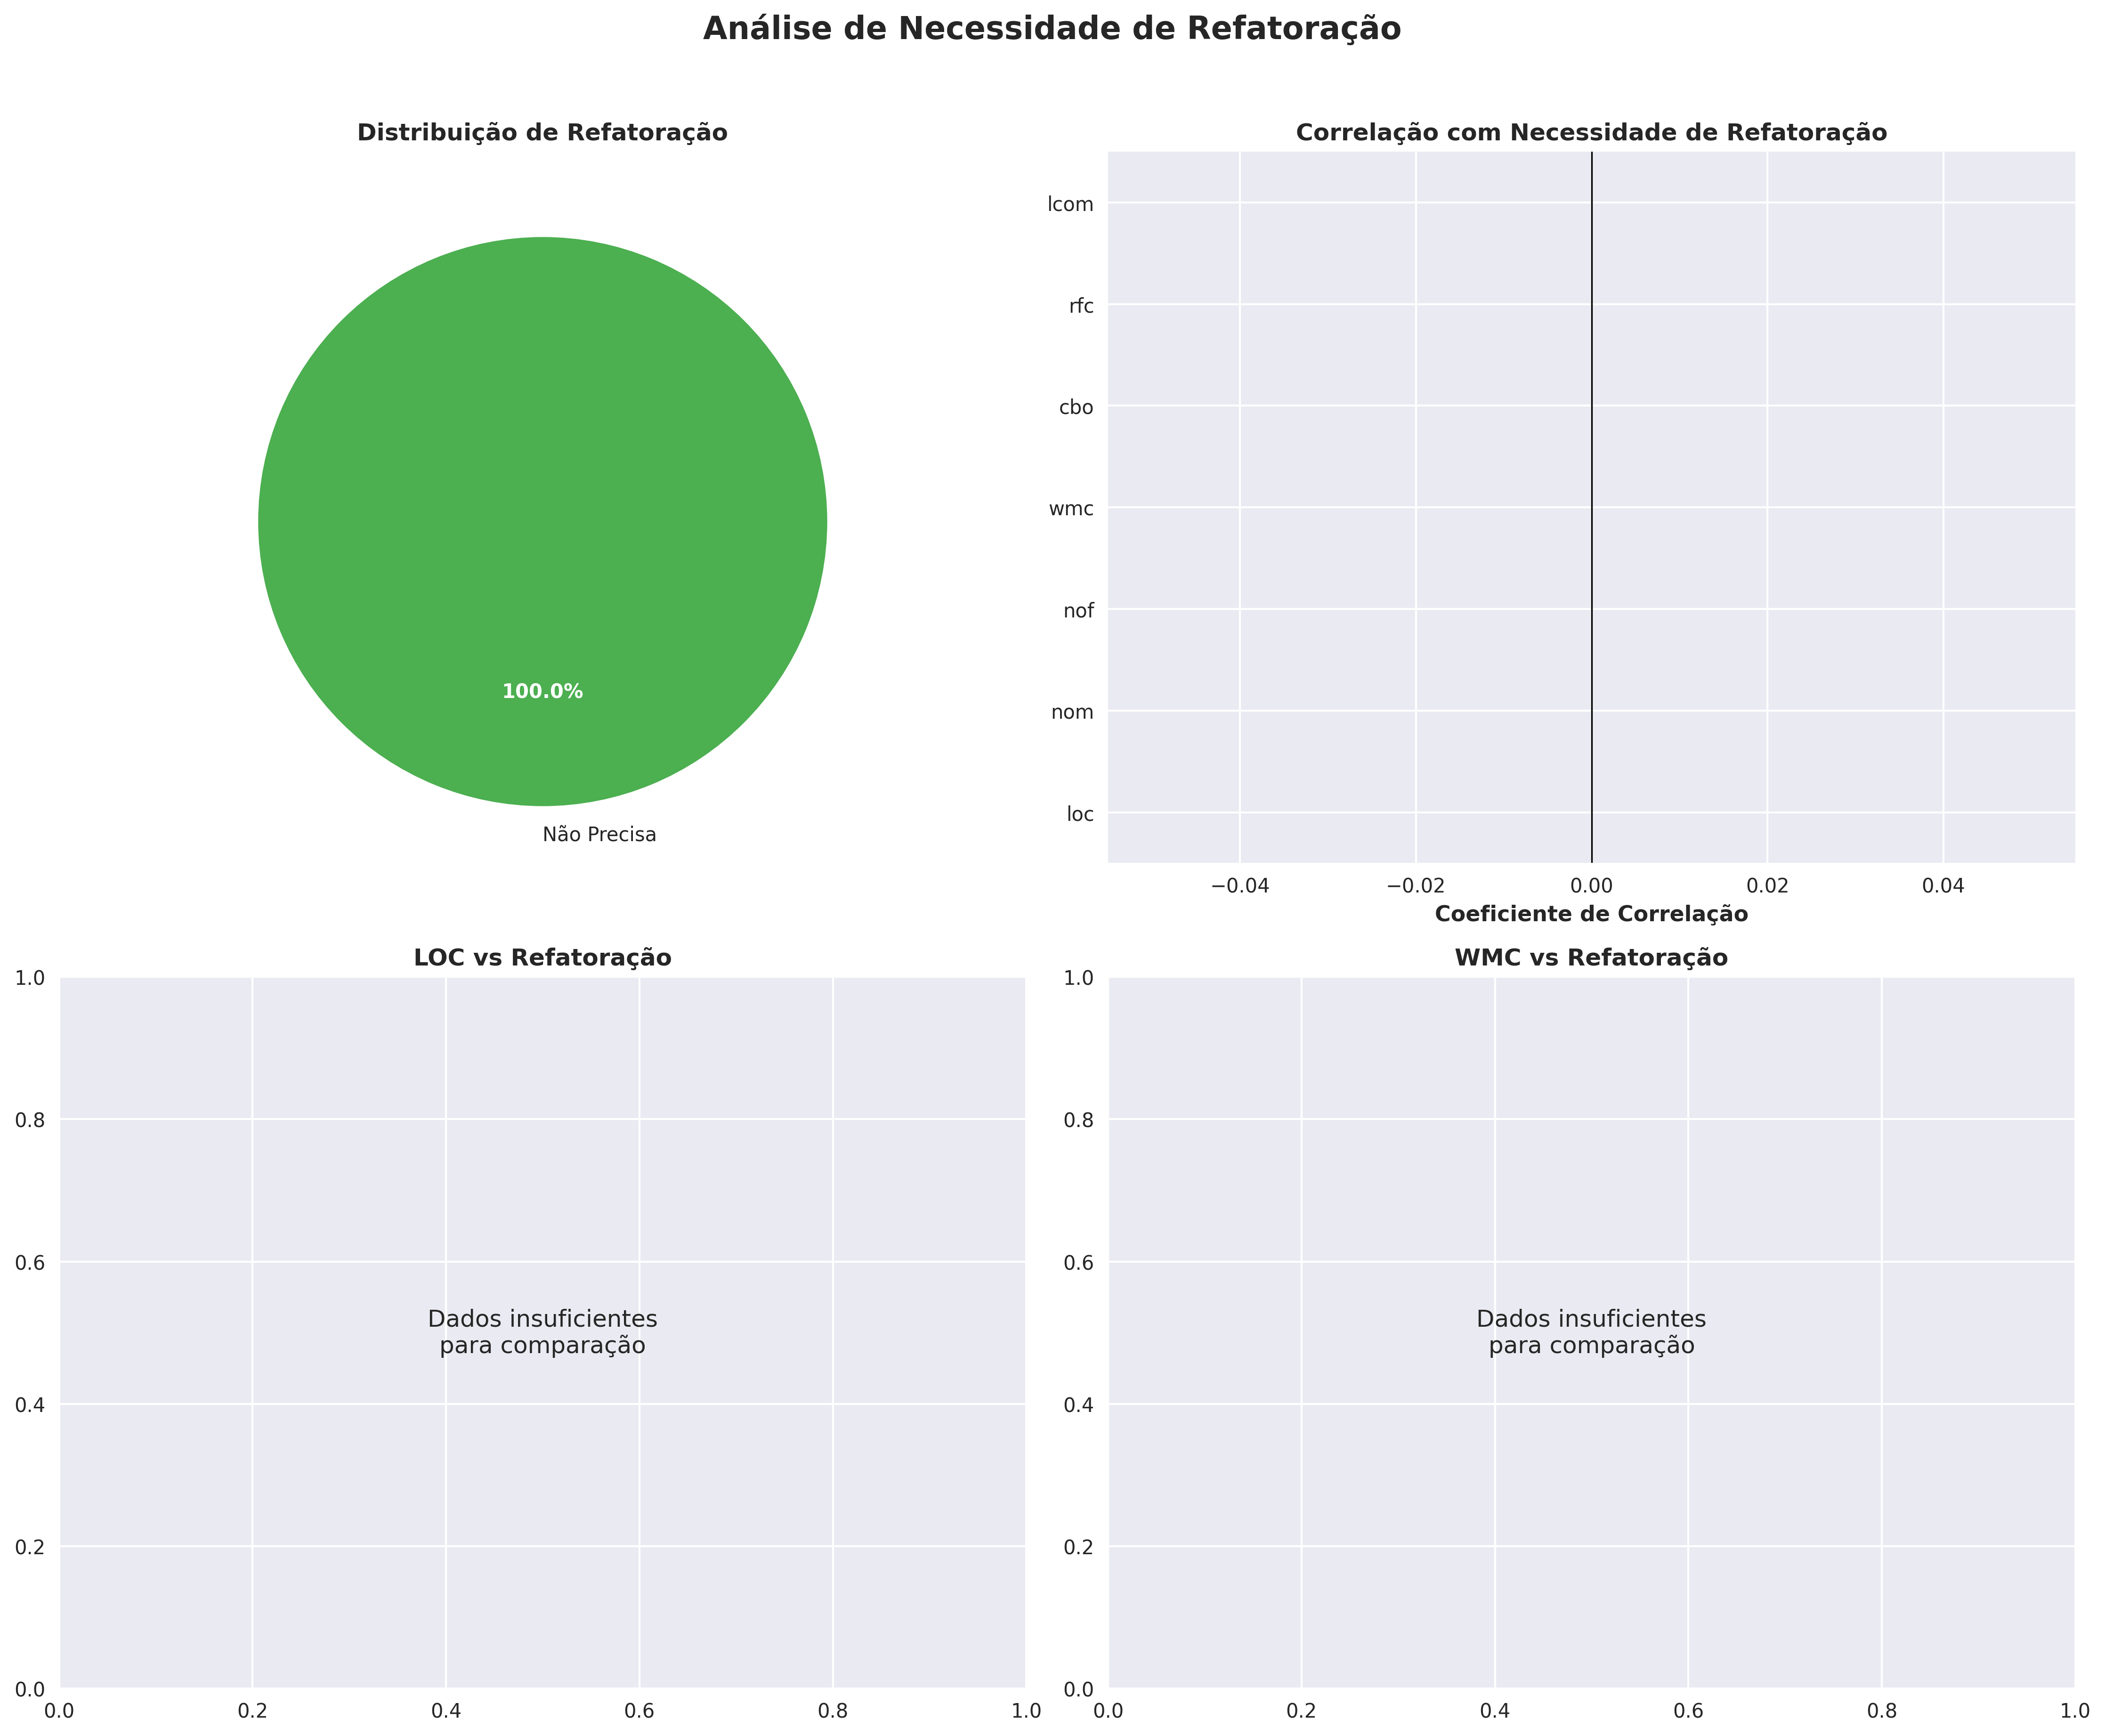

In [10]:
# Análise de Refatoração
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle(
    "Análise de Necessidade de Refatoração", fontsize=16, fontweight="bold", y=1.02
)

# Distribuição da variável target
ax1 = axes[0, 0]
refactoring_counts = df["refactoring_needed"].value_counts()

# Verificar se temos ambos os valores (0 e 1)
if len(refactoring_counts) == 2:
    colors = ["#4CAF50", "#F44336"]
    labels = ["Não Precisa", "Precisa"]
    explode = (0.05, 0.05)
elif len(refactoring_counts) == 1:
    # Se só tem um valor, ajustar cores e labels
    colors = ["#4CAF50"] if refactoring_counts.index[0] == 0 else ["#F44336"]
    labels = ["Não Precisa"] if refactoring_counts.index[0] == 0 else ["Precisa"]
    explode = (0.05,)
else:
    # Fallback para dados inesperados
    colors = ["#2196F3"] * len(refactoring_counts)
    labels = [f"Classe {i}" for i in refactoring_counts.index]
    explode = (0.05,) * len(refactoring_counts)

wedges, texts, autotexts = ax1.pie(
    refactoring_counts.values,
    labels=labels,
    autopct="%1.1f%%",
    colors=colors,
    startangle=90,
    explode=explode,
)
for autotext in autotexts:
    autotext.set_color("white")
    autotext.set_fontweight("bold")
ax1.set_title("Distribuição de Refatoração", fontweight="bold")

# Métricas que mais influenciam refatoração
ax2 = axes[0, 1]
if "refactoring_needed" in corr_matrix.columns:
    refactoring_corr = corr_matrix["refactoring_needed"].drop(
        "refactoring_needed", errors="ignore"
    )
    if len(refactoring_corr) > 0:
        refactoring_corr.sort_values().plot.barh(ax=ax2, color="#2196F3")
        ax2.set_title("Correlação com Necessidade de Refatoração", fontweight="bold")
        ax2.set_xlabel("Coeficiente de Correlação", fontweight="bold")
        ax2.axvline(x=0, color="black", linewidth=0.8)
    else:
        ax2.text(
            0.5,
            0.5,
            "Dados insuficientes\npara análise",
            ha="center",
            va="center",
            transform=ax2.transAxes,
            fontsize=12,
        )
        ax2.set_title("Correlação com Refatoração", fontweight="bold")
else:
    ax2.text(
        0.5,
        0.5,
        "Variável target\nnão encontrada",
        ha="center",
        va="center",
        transform=ax2.transAxes,
        fontsize=12,
    )
    ax2.set_title("Correlação com Refatoração", fontweight="bold")

# Comparação de LOC por necessidade de refatoração
ax3 = axes[1, 0]
if "refactoring_needed" in df.columns and len(df["refactoring_needed"].unique()) > 1:
    sns.boxplot(
        data=df, x="refactoring_needed", y="loc", ax=ax3, palette=["#4CAF50", "#F44336"]
    )
    ax3.set_title("LOC vs Necessidade de Refatoração", fontweight="bold")
    ax3.set_xlabel("Precisa de Refatoração", fontweight="bold")
    ax3.set_ylabel("Linhas de Código (LOC)", fontweight="bold")
else:
    ax3.text(
        0.5,
        0.5,
        "Dados insuficientes\npara comparação",
        ha="center",
        va="center",
        transform=ax3.transAxes,
        fontsize=12,
    )
    ax3.set_title("LOC vs Refatoração", fontweight="bold")

# Comparação de Complexidade (WMC)
ax4 = axes[1, 1]
if "refactoring_needed" in df.columns and len(df["refactoring_needed"].unique()) > 1:
    sns.boxplot(
        data=df, x="refactoring_needed", y="wmc", ax=ax4, palette=["#4CAF50", "#F44336"]
    )
    ax4.set_title("Complexidade (WMC) vs Refatoração", fontweight="bold")
    ax4.set_xlabel("Precisa de Refatoração", fontweight="bold")
    ax4.set_ylabel("Complexidade Weighted Methods (WMC)", fontweight="bold")
else:
    ax4.text(
        0.5,
        0.5,
        "Dados insuficientes\npara comparação",
        ha="center",
        va="center",
        transform=ax4.transAxes,
        fontsize=12,
    )
    ax4.set_title("WMC vs Refatoração", fontweight="bold")

plt.tight_layout()
plt.show()

# Estatísticas e Engenharia de Features

In [11]:
# Estatísticas Detalhadas
print("ESTATÍSTICAS DETALHADAS:")
print("=" * 50)
for col in metrics_cols:
    print(f"\n{col.upper()}:")
    print(f"  Média: {df[col].mean():.2f}")
    print(f"  Mediana: {df[col].median():.2f}")
    print(f"  Desvio Padrão: {df[col].std():.2f}")
    print(f"  Mínimo: {df[col].min()}")
    print(f"  Máximo: {df[col].max()}")
    print(f"  Skewness: {df[col].skew():.2f}")

# Informações sobre a variável target
if "refactoring_needed" in df.columns:
    print(f"\nVARIÁVEL TARGET (refactoring_needed):")
    print(f"  Distribuição: {df['refactoring_needed'].value_counts().to_dict()}")
    print(
        f"  Proporção: {(df['refactoring_needed'].mean() * 100):.1f}% precisam de refatoração"
    )

ESTATÍSTICAS DETALHADAS:

LOC:
  Média: 329.00
  Mediana: 329.00
  Desvio Padrão: 0.00
  Mínimo: 329
  Máximo: 329
  Skewness: 0.00

NOM:
  Média: 0.36
  Mediana: 0.00
  Desvio Padrão: 0.50
  Mínimo: 0
  Máximo: 1
  Skewness: 0.67

NOF:
  Média: 3.14
  Mediana: 3.00
  Desvio Padrão: 3.51
  Mínimo: 0
  Máximo: 12
  Skewness: 1.29

WMC:
  Média: 0.36
  Mediana: 0.00
  Desvio Padrão: 0.50
  Mínimo: 0
  Máximo: 1
  Skewness: 0.67

CBO:
  Média: 0.00
  Mediana: 0.00
  Desvio Padrão: 0.00
  Mínimo: 0
  Máximo: 0
  Skewness: 0.00

RFC:
  Média: 2.29
  Mediana: 0.00
  Desvio Padrão: 4.30
  Mínimo: 0
  Máximo: 14
  Skewness: 2.01

LCOM:
  Média: 0.00
  Mediana: 0.00
  Desvio Padrão: 0.00
  Mínimo: 0
  Máximo: 0
  Skewness: 0.00

VARIÁVEL TARGET (refactoring_needed):
  Distribuição: {0: 14}
  Proporção: 0.0% precisam de refatoração


# Engenharia de Features e Salvamento

In [12]:
# Engenharia de Features
# Correção de inconsistências
df.loc[df["wmc"] < df["nom"], "wmc"] = df.loc[df["wmc"] < df["nom"], "nom"]

# Novas features
df["methods_per_field"] = df["nom"] / (df["nof"] + 1)
df["loc_per_method"] = df["loc"] / (df["nom"] + 1)
df["complexity_per_method"] = df["wmc"] / (df["nom"] + 1)
df["is_large_entity"] = (df["loc"] > df["loc"].quantile(0.75)).astype(int)
df["is_complex"] = (df["wmc"] > df["wmc"].quantile(0.75)).astype(int)

# Salvar dataset limpo
output_file = "go_metrics_clean.csv"
df.to_csv(output_file, index=False)

print(f"\nPROCESSO CONCLUÍDO!")
print(f"Dataset limpo salvo: {output_file}")
print(f"Dimensões finais: {df.shape[0]} linhas, {df.shape[1]} colunas")


PROCESSO CONCLUÍDO!
Dataset limpo salvo: go_metrics_clean.csv
Dimensões finais: 14 linhas, 16 colunas
